# Forecasting Electricity Demand with DeepAR

In this notebook, will see how to:
* Prepare and process a dataset using a remote distributed Spark Cluster
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively (_WIP_)


In [4]:
%load_ext sagemaker_studio_analytics_extension.magics
%sm_analytics emr connect --verify-certificate False --cluster-id j-206FZFOB4FS8U --auth-type None   

The sagemaker_studio_analytics_extension.magics extension is already loaded. To reload it, use:
  %reload_ext sagemaker_studio_analytics_extension.magics
Successfully read emr cluster(j-206FZFOB4FS8U) details
Initiating EMR connection..
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1700592358949_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
{"namespace": "sagemaker-analytics", "cluster_id": "j-206FZFOB4FS8U", "error_message": null, "success": true, "service": "emr", "operation": "connect"}


## Dataset

We'll use a ~700MB dataset of energy consumption by 370 clients over time. This [dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) comes from the UCI Machine Learning Repostiory and was used in the academic papers [[1](https://media.nips.cc/nipsbooks/nipspapers/paper_files/nips29/reviews/526.html)] and [[2](https://arxiv.org/abs/1704.04110)].  The dataset comes in the following format:

|    | date                | client   |   value |
|---:|:--------------------|:---------|--------:|
|  0 | 2011-01-01 00:15:00 | MT_001   |       0 |
|  1 | 2011-01-01 00:30:00 | MT_001   |       0 |
|  2 | 2011-01-01 00:45:00 | MT_001   |       0 |
|  3 | 2011-01-01 01:00:00 | MT_001   |       0 |
|  4 | 2011-01-01 01:15:00 | MT_001   |       0 |

The first column contains the timestamp of the observation in 15 min increments. The `client` column uniquely identifies each timeseries (i.e. the customer), and the `value` column provides the electricity (kW) usage for that interval.


## Notebook Scoped Dependencies
These allow for on-the-fly installation of python libraries without restarting your session, ensuring dependency isolation unique to each notebook. These libraries can be easily replicated across different clusters and are automatically removed after the session ends.

In [5]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1700592358949_0005,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1700592358949_0005,pyspark,idle,Link,Link,None,✔


In [6]:
# Check Pre-Installed Python Packages from Bootstrap
sc.list_packages()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- ----------
aws-cfn-bootstrap          2.0
beautifulsoup4             4.9.3
boto                       2.49.0
boto3                      1.18.63
botocore                   1.21.65
certifi                    2023.11.17
charset-normalizer         2.0.12
click                      8.1.3
cycler                     0.11.0
Cython                     0.29.24
distlib                    0.3.7
docutils                   0.14
filelock                   3.12.2
idna                       3.4
importlib-metadata         6.7.0
jmespath                   0.10.0
joblib                     1.2.0
kiwisolver                 1.4.5
lockfile                   0.11.0
lxml                       4.9.1
matplotlib                 3.4.3
mysqlclient                1.4.2
nltk                       3.7
nose                       1.3.4
numpy                      1.21.2
pandas                     1.2.5
Pillow                     9.5.0
pip                      

In [7]:
# Install pyarrow to run vectorized UDFs
sc.install_pypi_package("pyarrow") 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Initial Setup

1. Importing the sagemaker SDK library
2. Setting up variables for the execution role, bucket, and S3 location of our data and artifacts
3. Creating a schema that will be used by spark when reading the data

In [8]:
%%local

import sagemaker
from sagemaker import get_execution_role


role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
key_prefix = "forecasting-electricity"
s3_processed_data_location = f"s3://{bucket}/{key_prefix}/data/processed/" # location where spark writes the processed data for training

s3_input_data_location = "s3://ws-assets-prod-iad-r-iad-ed304a55c2ca1aee/9e2e09b0-7142-4ab8-8b89-531349b817b9/deep-ar-electricity/LD2011_2014.csv.gz"
schema = "date TIMESTAMP, client STRING, value FLOAT" # source data schema

Now we have all we need to preprocess the data with spark. We'll send to spark cluster the location of the input data, the S3 location of where we'd like the output to go, and the schema information

In [9]:
%%send_to_spark -i s3_input_data_location -t str -n s3_input_data_location

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_input_data_location' as 's3_input_data_location' to Spark kernel

In [10]:
%%send_to_spark -i s3_processed_data_location -t str -n s3_processed_data_location

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_processed_data_location' as 's3_processed_data_location' to Spark kernel

In [11]:
%%send_to_spark -i schema -t str -n schema

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'schema' as 'schema' to Spark kernel

# Data preprocessing with Apache Spark

For DeepAR we'll need to transform the timeseries data into a json lines format where each line contains a json object representing each client and having the following schema: <br>
`{"start": ..., "target": [0, 0, 0, 0], "dynamic_feat": [[0, 1, 1, 0]], "cat": [0, 0]}` <br>
[AWS SageMaker DeepAR Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)

We'll only use 
1. the `start` attribute which contains the start date for the timesries,
2. the `target` attribute which contains the observations, and 
3. the `cat` attribute with which will encode each client as a category. DeepAR supports providing additional categorical and continuous features to improve the quality of the forecast

Here we will read the data from S3, and then use a compination of PySpark and PandasUDFs to get the data into the right format

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

import random
import pyspark.sql.functions as fn
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, ArrayType, DoubleType, StringType, IntegerType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
data = (spark
        .read
        .schema(schema)
        .options(sep =',', header=True, mode="FAILFAST", timestampFormat="yyyy-MM-dd HH:mm:ss")
        .csv(s3_input_data_location)
       )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Caching for faster performance
data.cache() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[date: timestamp, client: string, value: float]

In [15]:
%%pretty
data.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

date,client,value
2011-01-01 00:15:00,MT_001,0.0
2011-01-01 00:30:00,MT_001,0.0
2011-01-01 00:45:00,MT_001,0.0
2011-01-01 01:00:00,MT_001,0.0
2011-01-01 01:15:00,MT_001,0.0
2011-01-01 01:30:00,MT_001,0.0
2011-01-01 01:45:00,MT_001,0.0
2011-01-01 02:00:00,MT_001,0.0
2011-01-01 02:15:00,MT_001,0.0
2011-01-01 02:30:00,MT_001,0.0


In [16]:
# Resample from 15min intervals to one hour to speed up training
data = (data.groupBy(fn.date_trunc("HOUR", fn.col("date")).alias("date"),
                    fn.col("client"))
 .agg(fn.mean("value").alias("value"))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Create a dictionary to Integer encode each client
client_list = data.select("client").distinct().collect()
client_list = [rec["client"] for rec in client_list]
client_encoder = dict(zip(client_list, range(len(client_list)))) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Let's visualize the timeseries data for a random subset of clients

In [18]:
random_client_list = random.sample(client_list, 6)

random_clients_pandas_df = (data.where(fn.col("client")
                                            .isin(random_client_list)) 
                                 .groupBy("date")
                                 .pivot("client").max().toPandas()
                                )
random_clients_pandas_df.set_index("date", inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

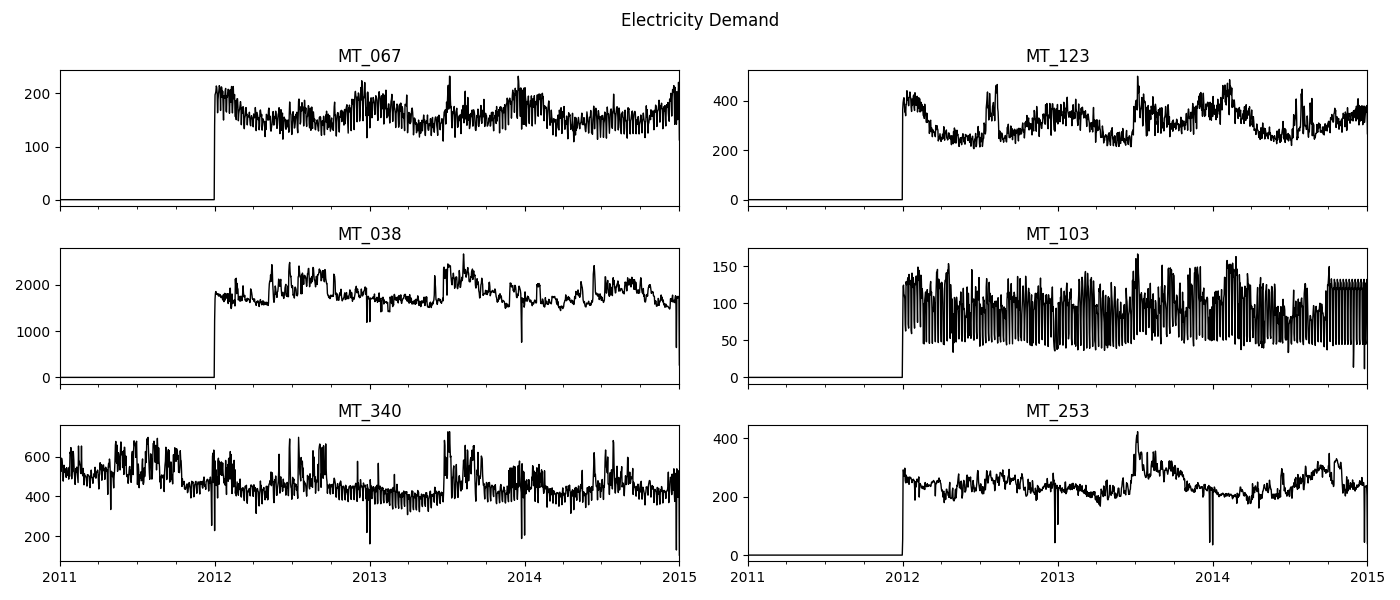

In [19]:
plt.clf()
axes = random_clients_pandas_df.resample("1D").max().plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=random_client_list,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color="k")
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle("Electricity Demand")
plt.gcf().tight_layout()

%matplot plt

DeepAR requires no gaps in your data. So for example if you have data that only comes in Monday to Friday (e.g. stock trading activity), we'd have to insert NaN data points to account for Saturdays and Sundays. A quick way to check if our data has any gaps is to aggregate by the day of the week. Running the commands below we can see that the difference between the count and the lowest count is 24 Hours which is ok as it just means that the last datapoint falls midweek. Also the counts match across all customers so it appears that this dataset does not have any gaps

In [20]:
weekday_counts = (data
 .withColumn("dayofweek", fn.dayofweek("date"))
 .groupBy("client")
 .pivot("dayofweek")
 .count()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
%%pretty
weekday_counts.show(5) # show aggregates for several clients
weekday_counts.agg(*[fn.min(col) for col in weekday_counts.columns[1:]]).show() # show minimum counts of observations across all clients
weekday_counts.agg(*[fn.max(col) for col in weekday_counts.columns[1:]]).show() # show maximum counts of observations across all clients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Split our timeseries datasets

To ensure there is no data leakage between our training and test dataset

In [25]:
train_start_date = data.select(fn.min("date").alias("date")).collect()[0]["date"]
test_start_date = "2014-01-01"
end_date = data.select(fn.max("date").alias("date")).collect()[0]["date"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
print(f"overall date span: {train_start_date} to {end_date}")

In [27]:
# split the data into train and test set
train_data = data.where(fn.col("date") < test_start_date)
test_data = data.where(fn.col("date") >= test_start_date)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As mentioned above, DeepAR requires data in a specific fromat, we use pandasUDF to wrangle our data into it. In recent versions, we can also use PySpark dataframes

In [28]:
# pandasUDFs require an output schema. This one matches the format required for DeepAR
deep_ar_schema = StructType([StructField("target", ArrayType(DoubleType())),
                             StructField("cat", ArrayType(IntegerType())),
                             StructField("start", StringType())
                            ])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
@pandas_udf(deep_ar_schema, PandasUDFType.GROUPED_MAP)
def prep_deep_ar(df):
    
    df = df.sort_values(by="date")
    client_name = df.loc[0, "client"]
    targets = df["value"].values.tolist()
    cat = [client_encoder[client_name]]
    start = str(df.loc[0,"date"])
    
    return pd.DataFrame([[targets, cat, start]], columns=["target", "cat", "start"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
train_data = train_data.groupBy("client").apply(prep_deep_ar)
train_data.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+-------------------+
|              target| cat|              start|
+--------------------+----+-------------------+
|[0.0, 0.0, 0.0, 0...| [9]|2011-03-06 06:00:00|
|[0.0, 0.0, 0.0, 0...| [7]|2011-01-27 00:00:00|
|[0.0, 0.0, 0.0, 0...| [6]|2011-01-02 12:00:00|
|[0.0, 0.0, 0.0, 0...|[10]|2011-01-04 15:00:00|
|[0.0, 0.0, 0.0, 0...| [1]|2011-02-27 01:00:00|
+--------------------+----+-------------------+
only showing top 5 rows

/mnt/yarn/usercache/livy/appcache/application_1700592358949_0005/container_1700592358949_0005_01_000001/pyspark.zip/pyspark/sql/pandas/group_ops.py:102: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.

In [31]:
# Set flag so that _SUCCESS meta files are not written to S3
# DeepAR actually skips these files anyway, but it's a good practice when using directories as inputs to algorithms
spark.conf.set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we have our data in the right format, we are we are going to write it into the S3 buckets. This will be stored as shards for distributed processing 

In [32]:
# data is ready for DeepAR an can be written to the specified output destination
train_data.write.mode("overwrite").json(s3_processed_data_location)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
%%local
sagemaker.s3.S3Downloader().list(s3_processed_data_location)

['s3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00000-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00001-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00002-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00003-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00004-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00005-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-793217038115/forecasting-electricity/data/processed/part-00006-5083e253-62d8-4ac6-b8b5-43ff638e6207-c000.json',
 's3://sagemaker-us-east-1-

# Train model with SageMaker DeepAR
Switching back to the local notebook, we can now configure a DeepAR training job <br>
We need to provide the location of the training data and specify several hyperparameters

In [34]:
%%local
from sagemaker import image_uris
image_uri = image_uris.retrieve("forecasting-deepar", sess.boto_region_name)
freq = '1H' # 1 hour frequency
prediction_length = 168  # predict one week forward
context_length = 168 # look at the past week of data
s3_output_path = f"s3://{bucket}/{key_prefix }/output"

In [35]:
%%local
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "5",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

We use Sagemaker estimators to setup a managed environment, which takes care of complexities associated with machine learning training and deployment.

In [36]:
%%local
deepar_estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    base_job_name="deepar-electricity-demand",
    hyperparameters=hyperparameters,
    output_path=s3_output_path
)

deepar_estimator.fit({"train": s3_processed_data_location})

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning:

Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/

INFO:sagemaker:Creating training-job with name: deepar-electricity-demand-2023-11-21-19-17-44-172


2023-11-21 19:17:44 Starting - Starting the training job...
2023-11-21 19:17:59 Starting - Preparing the instances for training......
2023-11-21 19:19:05 Downloading - Downloading input data...
2023-11-21 19:19:30 Training - Downloading the training image.........
2023-11-21 19:21:01 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[11/21/2023 19:21:17 INFO 139621919102784] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'aut

# Run Batch Inference 
Now that we have a trained model, let's setup a batch transform job. We will provide the final month of our training data (December 2013) as the input and have DeepAR forecast the first week of the test data. We will then compare the prediction against the actual values <br>
Note for DeepAR, we need to provide at a minimum of `context_length` worth of data points to get a forecast for the `prediction_length`. Providing more data during inference (ideally the enitre timeseries) could result in better predictions as DeepAR is better able to account for longer term trends

In [37]:
%%local
s3_batch_transform_input = f"s3://{bucket}/{key_prefix}/bt_input"

In [38]:
%%send_to_spark -i s3_batch_transform_input -t str -n s3_batch_transform_input

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_batch_transform_input' as 's3_batch_transform_input' to Spark kernel

In [39]:
# to avoid having to recreate a DeepAR input, we'll get the index of the start date of the batch transform input and slice the target column in the train_data
bt_input_start = "2013-12-01 00:00:00"
date_range = pd.date_range(train_start_date, end_date, freq="1H") # date range for the entire dataset
bt_start_index = date_range.get_loc(bt_input_start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
bt_input_data = train_data.select(fn.lit(bt_input_start).alias("start"), 
                                  fn.col("cat"),
                                  fn.slice("target", bt_start_index, 10_000).alias("target"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
bt_input_data.write.mode("overwrite").json(s3_batch_transform_input)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
%%local
s3_bt_output_path = f"s3://{bucket}/{key_prefix}/bt_output"

deepar_transformer = deepar_estimator.transformer(instance_count=1,
                                                  instance_type="ml.m5.xlarge",
                                                  strategy="SingleRecord",
                                                  assemble_with="Line",
                                                  accept="application/jsonlines",
                                                  output_path= s3_bt_output_path
                                                 )

INFO:sagemaker:Creating model with name: deepar-electricity-demand-2023-11-21-19-28-09-231


In [43]:
%%local
deepar_transformer.transform(s3_batch_transform_input, 
                             content_type="application/jsonlines", 
                             join_source="Input", 
                             split_type="Line",
                             logs=False)

INFO:sagemaker:Creating transform job with name: deepar-electricity-demand-2023-11-21-19-28-30-700


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTransformJob operation: The account-level service limit 'ml.m5.xlarge for transform job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

In [ ]:
%%send_to_spark -i s3_bt_output_path -t str -n s3_bt_output_path

In [ ]:
bt_output = spark.read.json(s3_bt_output_path) # read batch transform output from S3

## Visualize Forecast Results

In [ ]:
def plot_forecast(client, actual, time_range, predictions):
    
    
    p10 = predictions['quantiles']['0.1']
    p25 = predictions['quantiles']['0.2']
    p50 = predictions['quantiles']['0.5']
    p75 = predictions['quantiles']['0.8']
    p90 = predictions['quantiles']['0.9']
    prediction = predictions['mean']
    
    fig, ax = plt.subplots(figsize=(14,6))
    ts = ax.plot(time_range[-prediction_length:], prediction,  label="Prediction", marker="o")
    ts = ax.plot(time_range[:len(actual)], actual, label="Actual", marker="X")
    ax.fill_between(time_range[-prediction_length:], p10, p25, alpha=0.5, label="P10-P20", color="#2A9D8F")
    ax.fill_between(time_range[-prediction_length:], p25, p75, alpha=0.5, label="P20-P80", color="#E9C46A")
    ax.fill_between(time_range[-prediction_length:], p75, p90, alpha=0.5, label="P80-P90", color="#E76F51")
    ax.legend(loc="best")
    
    ax.set(title=f"{client} Electricity Demand Forecast", xlabel="date", ylabel="demand")

In [ ]:
# let's visualize the forecast of a single random customer and compare against the actual values
rnd_client, rnd_client_enc = random.choice(list(client_encoder.items()))
forecast = bt_output.filter(fn.col("cat")[0] == rnd_client_enc).collect()[0]["SageMakerOutput"].asDict()
prediction_length = len(forecast["mean"])

forecast_start_index = date_range.get_loc(test_start_date).start
forecast_end_index = forecast_start_index + prediction_length
forecast_date_range = date_range[forecast_start_index:forecast_end_index]
forecast_date_range_str = list(map(str, forecast_date_range.to_list()))
actual_values = (data
     .where((fn.col("client") == rnd_client) & 
            (fn.col("date").isin(forecast_date_range_str)))
     .orderBy("date")
     .toPandas()
    )["value"].values.tolist()

plt.clf()
plot_forecast(rnd_client, actual_values, forecast_date_range, forecast)
%matplot plt

# Cleanup


In [ ]:
%%cleanup -f

# Issues & Next Steps

_Unfortunately, I do not have the resources currently to run a batch transformation. I have created a request for the same._ 
Meanwhile, I pondered over how I can circumvent this issue and since the model is trained, whether it would be possible to deploy it to an endpoint and pass the batch input one record at a time. Below can be considered a rough pseudo-code for the process.

In [ ]:
%%local
deepar_predictor = deepar_estimator.deploy(initial_instance_count=1, 
                                           instance_type="ml.m5.xlarge")


In [ ]:
# Assuming 'prepare_data_for_prediction' formats the data for sending to the endpoint
data_for_prediction = prepare_data_for_prediction(train_data, bt_input_start, bt_start_index)


In [ ]:
%%local
# Serialize your input data to JSON (or the format accepted by your model)
serialized_data = json.dumps(data_for_prediction)

# Get predictions from the endpoint
response = deepar_predictor.predict(serialized_data, initial_args={"ContentType": "application/json"})
predictions = json.loads(response)  # Deserialize the response


In [ ]:
%%local
plt.clf()
plot_forecast(rnd_client, actual_values, forecast_date_range, predictions)
%matplot plt


In [ ]:
%%local
deepar_predictor.delete_endpoint()


This is not the ideal way to treat forecasting data and might hamper prediction even if(!) it works.

For future work, I can try incremental processing, where I consider only new or changed data since the last run. This would mean I have to train the DeepAR model in batches, separated by the date-time stamp and then fit on new data for predictions. 